# Later edits to files on Commons

In [T231952](https://phabricator.wikimedia.org/T231952), the second question is aiming to understand to what extent SDC has led to users updating structured data about existing media. It might be that users are instead adding structured data when uploading new media. This notebook seeks to answer this question.

Similarly as we did for part 3 (it was done before this), we'll use the `mediawiki_history` table to identify structured data edits, reusing approaches from our micro-contributions analysis. These can then be compared to other types of edits in order to learn when and how structured data is used.

Let's load some libraries and get moving.  

<font color= red>_**Note that all metrics calculated in this version of the notebook are different than the previous versions due to the inclusion of December 2019 data that is now available in the Data lake. **_</font>

In [1]:
from pyspark.sql.types import ArrayType, StringType

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

import datetime as dt

import pandas as pd
import numpy as np

In [2]:
# needed to show matplot plots?
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import colors

In [3]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Configuration variables
**UPDATE 2020-01-17:** Modified Config variables snapshot and end_date to include data from December 2019 in all the metrics. Refer to [T242816](https://phabricator.wikimedia.org/T242816) 

In [4]:
wmf_snapshot = '2019-12'
start_date = '2019-01-01' # first creation date of files we'll be measuring
end_date = '2020-01-01' # last creation date

## Approach

We'll use edit comments to identify structured data edits, and then use timestamps to measure *time to edit* since the page was created. Then, we'll plot a histogram to see if there's a reasonable cutoff we can use for separating edits happening around the initial upload from those happening later.

For non-SDC edits, we'll look for edits that added information to a page. These edits cannot be a revert, because that would mean it's reinstating a previous state of the file, nor should it have been reverted within 48 hours, as that would mean it's likely an unproductive edit.

In both cases, we'll only look at non-bot edits to files (`page_namespace = 6`) that have not been deleted. While there might also have been valid edits to deleted files, we are mainly interested in learning whether existing pages are updated with structured data. If we were to include deleted files, I think it would be necessary to be careful about what files were included so as to only measure "meaningful pages" (e.g. ignoring meaningless content). Determining what did and did not warrant deletion is outside the scope of this analysis.

## Cache edit data

As we'll be exploring and most likely querying the dataset multiple times, we might as well cache a subset of `mediawiki_history`.

In [5]:
edit_view_query = '''
CREATE TEMPORARY VIEW commons_edits
AS SELECT event_timestamp, page_creation_timestamp, event_comment,
    revision_text_bytes_diff, revision_is_identity_reverted,
    revision_seconds_to_identity_revert, revision_is_identity_revert
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "{start_date}"
AND event_timestamp < "{end_date}"
AND page_namespace = 6 -- only files
AND page_is_deleted = false -- only live pages
AND size(event_user_is_bot_by_historical) = 0 -- no bots
AND size(event_user_is_bot_by) = 0 -- no bots
'''

In [6]:
spark.sql(edit_view_query.format(
    snapshot = wmf_snapshot,
    start_date = start_date,
    end_date = end_date
)).collect()

[]

In [7]:
spark.sql('CACHE TABLE commons_edits').collect()

[]

## Time to edit for SDC

We'll grab data and plot a histogram for time from page creation to the first SDC edit for files that had either captions or statements added.

**UPDATE 2019-12-22:** Based on the results for Part 1, we added `wbcreateclaim-create` and `wbeditentity-update` because both of those had extensive use.

In [8]:
## Time between page creation and edit 

time_to_sdc_query = '''
SELECT unix_timestamp(event_timestamp) - unix_timestamp(page_creation_timestamp) AS time_to_edit
FROM commons_edits
WHERE event_comment REGEXP "^...wbsetclaim-create:.*?Special:EntityPage/(P\\\\d+)"
OR event_comment REGEXP "^...wbsetlabel-add:"
OR event_comment REGEXP "^...wbcreateclaim-create:"
OR event_comment REGEXP "^...wbeditentity-update:"
'''

In [9]:
time_to_sdc = spark.sql(time_to_sdc_query).toPandas()

In [10]:
time_to_sdc.loc[time_to_sdc['time_to_edit'] > 0].head()

,time_to_edit
0,116054678.0
1,53565778.0
2,1.0
3,158190656.0
4,1.0


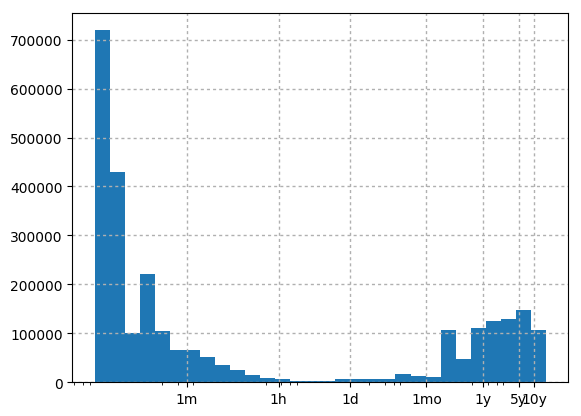

In [11]:
plt.style.use('default')

def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.xticks([60, 60*60, 24*60*60, 30*24*60*60, 365*24*60*60, 5*365*24*60*60, 10*365*24*60*60],
      ["1m", "1h", "1d", "1mo", "1y", "5y", "10y"])
    axes = plt.axes()
    axes.grid(linestyle=':', linewidth=1)


plot_loghist(time_to_sdc.loc[time_to_sdc['time_to_edit'] > 0]['time_to_edit'], 30)

The vertical lines in the histogram are 1 minute, 1 hour, 1 day, 1 month, 1 year, 5 years, and 10 years, by the way.

## Time to edit for non-SDC data

Here we look at time since an article was created for an edit that is not a structured edit, that added something to the file. The edit cannot be a revert, because that would mean it's reinstating a previous state of the file, nor should it have been reverted within 48 hours, as that would mean it's likely an unproductive edit.

In [12]:
## Time between page creation and edit 

time_to_data_query = '''
SELECT unix_timestamp(event_timestamp) - unix_timestamp(page_creation_timestamp) AS time_to_edit
FROM commons_edits
WHERE event_comment NOT REGEXP "^...wbsetclaim-create:.*?Special:EntityPage/(P\\\\d+)"
AND event_comment NOT REGEXP "^...wbsetlabel-add:"
AND revision_text_bytes_diff > 0
AND (revision_is_identity_reverted = false
     OR revision_seconds_to_identity_revert > 48 * 60 * 60)
AND revision_is_identity_revert = false
'''

In [13]:
time_to_data = spark.sql(time_to_data_query).toPandas()

In [14]:
time_to_data.loc[time_to_data['time_to_edit'] > 0].head()

,time_to_edit
1,67231959.0
2,387017361.0
4,210620304.0
5,22180.0
6,39720838.0


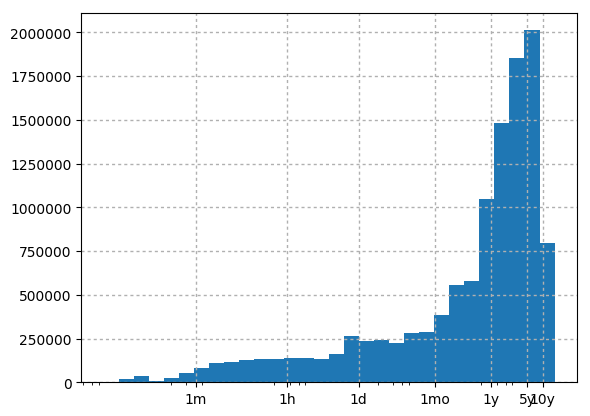

In [16]:
plot_loghist(time_to_data.loc[time_to_data['time_to_edit'] > 0]['time_to_edit'], 30)

Same vertical lines in the histogram at 1 minute, 1 hour, 1 day, 1 month, 1 year, 5 years, and 10 years.

## Summary, and what's next?

So far, we've learned that SDC edits (in 2019) most frequently occur right around the file upload. There's a cutoff around the 1 hour mark in the distribution of those edits. A second part of the distribution starts around the 1 month mark, but increases significantly around the 1 year mark and onwards. There are definitely older files that are being edited with structured data. Looks like there's roughly 500,000 SDC edits to >= 1 year old files.

For non-SDC edits (again made in 2019 so far), we see the majority of them being done to quite old files, often a year or older. There's about 7,000,000 edits to those. Activity on newly uploaded files seems to be quite limited, there's a clear jump up at 24 hours. Note that we've removed bots from these, so this means that commonists are making a lot of maintenance edits.

This also means that it'll be difficult for us to learn to what extent commonists are making substantially more of these edits now that SDC is available. The goal for SDC was a 10% increase. 500,000 vs 7,000,000 suggests that might be the case, though. I'll think about whether a straightforward comparison of those two numbers is reasonable or not.

## Time horizon for SDC edits

We see that for both SDC edits and non-SDC edits, one month is a reasonable threshold for longer-term maintenance edits. If the file is older than that, it means they're no longer making updates to the file. Let's make a comparison of number of SDC edits from 30–60 days 60–90 days, 90–120 days, 120–150 days, and 150–180 days, just to get an idea if there's actually an increase there or what we're seeing is the increase in the bucket size.

In [15]:
sdc_horizon_query = '''
WITH sdc_edits AS (
    SELECT unix_timestamp(event_timestamp) - unix_timestamp(page_creation_timestamp) AS time_to_edit
    FROM commons_edits
    WHERE event_comment REGEXP "^...wbsetclaim-create:.*?Special:EntityPage/(P\\\\d+)"
    OR event_comment REGEXP "^...wbsetlabel-add:"
    OR event_comment REGEXP "^...wbcreateclaim-create:"
    OR event_comment REGEXP "^...wbeditentity-update:"
)
SELECT 
    SUM(IF(time_to_edit BETWEEN 3600*24*30 AND 3600*24*60, 1, 0)) AS num_30,
    SUM(IF(time_to_edit BETWEEN 3600*24*60 AND 3600*24*90, 1, 0)) AS num_60,
    SUM(IF(time_to_edit BETWEEN 3600*24*90 AND 3600*24*120, 1, 0)) AS num_90,
    SUM(IF(time_to_edit BETWEEN 3600*24*120 AND 3600*24*150, 1, 0)) AS num_120,
    SUM(IF(time_to_edit BETWEEN 3600*24*150 AND 3600*24*180, 1, 0)) AS num_150
FROM sdc_edits
'''

In [16]:
sdc_horizons = spark.sql(sdc_horizon_query).toPandas()
sdc_horizons

,num_30,num_60,num_90,num_120,num_150
0,11667,12553,110951,7523,8291


We see that there's a substantial amount of edits in the second month, similar to the third month, and a huge increase in the fourth month. Because of this stability from 30 to 60 days, I find choosing a 30 day threshold to seem reasonable, otherwise we'd have to go much further, at 120 days, and that seems unreasonable.

# Comparison of number of SDC and non-SDC edits

We'll look at this overall so far in 2019, as well as edits done in Q1, Q2, and Q3 specifically.

In [17]:
overall_stats_query = '''
SELECT
    SUM(IF(event_timestamp >= "2019-01-01" AND event_timestamp < "2019-04-01"
           AND edit_type = "sdc", 1, 0)) AS sdc_q1,
    SUM(IF(event_timestamp >= "2019-01-01" AND event_timestamp < "2019-04-01"
           AND edit_type = "non-sdc", 1, 0)) AS non_sdc_q1,
    SUM(IF(event_timestamp >= "2019-04-01" AND event_timestamp < "2019-07-01"
           AND edit_type = "sdc", 1, 0)) AS sdc_q2,
    SUM(IF(event_timestamp >= "2019-04-01" AND event_timestamp < "2019-07-01"
           AND edit_type = "non-sdc", 1, 0)) AS non_sdc_q2,
    SUM(IF(event_timestamp >= "2019-07-01" AND event_timestamp < "2019-10-01"
           AND edit_type = "sdc", 1, 0)) AS sdc_q3,
    SUM(IF(event_timestamp >= "2019-07-01" AND event_timestamp < "2019-10-01"
           AND edit_type = "non-sdc", 1, 0)) AS non_sdc_q3,
    SUM(IF(event_timestamp >= "2019-10-01" AND event_timestamp < "2020-01-01"
           AND edit_type = "sdc", 1, 0)) AS sdc_q4,
    SUM(IF(event_timestamp >= "2019-10-01" AND event_timestamp < "2020-01-01"
           AND edit_type = "non-sdc", 1, 0)) AS non_sdc_q4,
    SUM(IF(event_timestamp >= "2019-01-01" AND event_timestamp < "2020-01-01"
           AND edit_type = "sdc", 1, 0)) AS sdc_overall,
    SUM(IF(event_timestamp >= "2019-01-01" AND event_timestamp < "2020-01-01"
           AND edit_type = "non-sdc", 1, 0)) AS non_sdc_overall
FROM (
    SELECT "sdc" AS edit_type, event_timestamp, 
           unix_timestamp(event_timestamp) - unix_timestamp(page_creation_timestamp) AS time_to_edit
    FROM commons_edits
    WHERE event_comment REGEXP "^...wbsetclaim-create:.*?Special:EntityPage/(P\\\\d+)"
    OR event_comment REGEXP "^...wbsetlabel-add:"
    OR event_comment REGEXP "^...wbcreateclaim-create:"
    OR event_comment REGEXP "^...wbeditentity-update:"
    UNION ALL
    SELECT "non-sdc" AS edit_type, event_timestamp,
           unix_timestamp(event_timestamp) - unix_timestamp(page_creation_timestamp) AS time_to_edit
    FROM commons_edits
    WHERE event_comment NOT REGEXP "^...wbsetclaim-create:.*?Special:EntityPage/(P\\\\d+)"
    AND event_comment NOT REGEXP "^...wbsetlabel-add:"
    AND event_comment NOT REGEXP "^...wbcreateclaim-create:"
    AND event_comment NOT REGEXP "^...wbeditentity-update:"
    AND revision_text_bytes_diff > 0
    AND (revision_is_identity_reverted = false
         OR revision_seconds_to_identity_revert > 48 * 60 * 60)
    AND revision_is_identity_revert = false
)
WHERE time_to_edit >= 60*60*24*30
'''

In [18]:
overall_stats = spark.sql(overall_stats_query).toPandas()

<font color= purple>**The metrics given below have been calculated with December 2019 snapshot. As a result when compared to the previous version of the notebook, the values have slightly reduced because the query only consideres live pages and not deleted pages. Number of live pages may have possibly reduced from Nov to Dec 2019, which could explain the drop. **</font>

In [19]:
overall_stats

,sdc_q1,non_sdc_q1,sdc_q2,non_sdc_q2,sdc_q3,non_sdc_q3,sdc_q4,non_sdc_q4,sdc_overall,non_sdc_overall
0,29157,2438752,65859,2098058,389493,2203395,295302,2267613,779811,9007818


What proportions does that gives us on a per-quarter basis and overall?

### Q1 2019

In [20]:
round(100 * overall_stats['sdc_q1'] / (overall_stats['sdc_q1'] + overall_stats['non_sdc_q1']), 1)

0    1.2
dtype: float64

### Q2 2019

In [21]:
round(100 * overall_stats['sdc_q2'] / (overall_stats['sdc_q2'] + overall_stats['non_sdc_q2']), 1)

0    3.0
dtype: float64

### Q3 2019

In [22]:
round(100 * overall_stats['sdc_q3'] / (overall_stats['sdc_q3'] + overall_stats['non_sdc_q3']), 1)

0    15.0
dtype: float64

### Q4 2019

~~So far in Q4, meaning the months of October and November.~~   
**Update 2020-01-17:** Modified config variable end_date to include December 2019 data

In [23]:
round(100 * overall_stats['sdc_q4'] / (overall_stats['sdc_q4'] + overall_stats['non_sdc_q4']), 1)

0    11.5
dtype: float64

### 2019 overall

In [24]:
round(100 * overall_stats['sdc_overall'] / (overall_stats['sdc_overall'] + overall_stats['non_sdc_overall']), 1)

0    8.0
dtype: float64